In [ ]:
# default_exp diffusion_distance_flow_embedder
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import directed_graphs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning flow around a fixed diffusion map

Continuing the explorations of 05c05, we break the problem into component pieces:
1. Learning the diffusion map (via a diffusion-map-regularized autoencoder), without bothering with the flows
2. Learning flows around a fixed diffusion map

In this notebook, we focus on the second problem. We'll build an `embedder` class that slots into our architecture to provide a set of diffusion mapped points as the embedding ground truth, which will remain fixed during training. We'll use a single loss -- the KL Divergence between the single-step diffusion probabilities in the ambient space and the embedding space.

Along the way, we'll investigate various interesting subproblems, such as: how does the diffusion map change on a directed graph (when flow is taken into account)? And what form of flow-based penalty is best for our network?

# The Diffusion Map
To begin, we'll create a class meant to be slotted in as an "embedder" in our MultiscaleDiffusionFlowEmbedder. When initialized, it will compute and store the diffusion map. When subsequently prompted to embed points, it will return the stored diffusion map, stripped of gradients.

In [ ]:
# export
import torch.nn as nn
from scipy.sparse import diags
from directed_graphs.utils import make_sparse_safe, diffusion_coordinates
class FixedDiffusionMapEmbedding(nn.Module):
    """
    Computes the diffusion map of the provided data.
    If `precompute = True`, computes diffusion map of input graph when initialized 
    and returns this map whenever called (assuming that all subsequent input points
    are the same as initially)
    When false, dynamically computes diffusion map on passed points.
    (False is not yet implemented.)
    """
    def __init__(self, P_graph_torch, t, precompute = True, embedding_dimension=2, device=torch.device('cpu'), **kwargs):
        super().__init__()
        self.t = t
        self.device = device
        # convert P_graph to numpy (nothing we do past here needs to be differentiable)
        P_graph = copy.copy(P_graph_torch).detach().cpu().numpy()
        # make sparse array
        P_graph = make_sparse_safe(P_graph)
        # turn into P_symmetric, by multiplying 
        # D^{1/2} D^{-1} P D^{-1/2}
        D = P_graph.sum(axis = 0)
        D_negative_one_half = diags(D ** (-0.5))
        D_positive_one_half = diags(D ** (0.5))
        P_symmetric = D_positive_one_half @ P_graph @ D_negative_one_half
        # pass to diffusion map function
        diff_map = diffusion_coordinates(P_symmetric, D, t=t)
        print("diff map is", diff_map)
        self.diff_coords = diff_map[:embedding_dimension]
        self.diff_coords = self.diff_coords.T
        self.diff_coords = self.diff_coords.real
        self.diff_coords = torch.tensor(self.diff_coords.copy())
        self.diff_coords = self.diff_coords.to(device)
        print(self.diff_coords.shape)
    def forward(self, X, **kwargs):
        return self.diff_coords
        

In [ ]:
# export
import copy
from directed_graphs.multiscale_flow_embedder import MultiscaleDiffusionFlowEmbedder
from directed_graphs.flow_embedding_training_utils import FETrainer, visualize_points, save_embedding_visualization
from directed_graphs.diffusion_flow_embedding import affinity_matrix_from_pointset_to_pointset
import torch.nn.functional as F
class FlowEmbedderAroundDiffusionMap(FETrainer):
    def __init__(self, X, flows, labels, device = device, sigma_graph = 1, flow_strength_graph = 1):
        super().__init__(X, flows, labels, device = device)
        self.vizfiz = [
            save_embedding_visualization,
            visualize_points,
        ]
        loss_weights = {
            "diffusion":1,
            "smoothness":0,
            "reconstruction":0,
            "diffusion map regularization":0,
            "flow cosine loss": 0,
        }
        P_graph = affinity_matrix_from_pointset_to_pointset(X,X,flows,sigma=sigma_graph,flow_strength=0)
        P_graph = F.normalize(P_graph, p=1, dim=1)
        self.FE = MultiscaleDiffusionFlowEmbedder(
            X = X,
            flows = flows,
            sigma_graph = sigma_graph,
            flow_strength_graph = flow_strength_graph,
            device = device,
            use_embedding_grid = False,
            embedder = FixedDiffusionMapEmbedding(P_graph, t=1, device=device)
        ).to(device)
        self.title = "Diffusion Distance FE"
        

Here is our dataset:

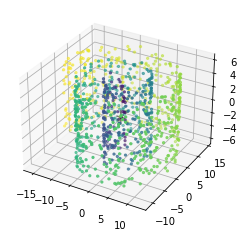

In [ ]:
from directed_graphs.datasets import directed_swiss_roll_uniform, plot_directed_3d, affinity_grid_search
X, flow, labels = directed_swiss_roll_uniform(num_nodes=1000, num_spirals=2.5, radius=1, height=12, xtilt=0, ytilt=0)
plot_directed_3d(X, flow, labels, mask_prob=0.5)

And here is our quest to find the right sigma value. Because assymetric kernels violate the *spectral theorem*'s guarantee of real-valued eigenvectors, thethe diffusion map of a directed graph includes complex values. It's unclear whether this remains a good embedding.

To avoid it, we'll set the influence of flow in our kernel to 0. Sigma = 1 gives a good ray of sunshine that doesn't illuminate the spurious folds of the roll.

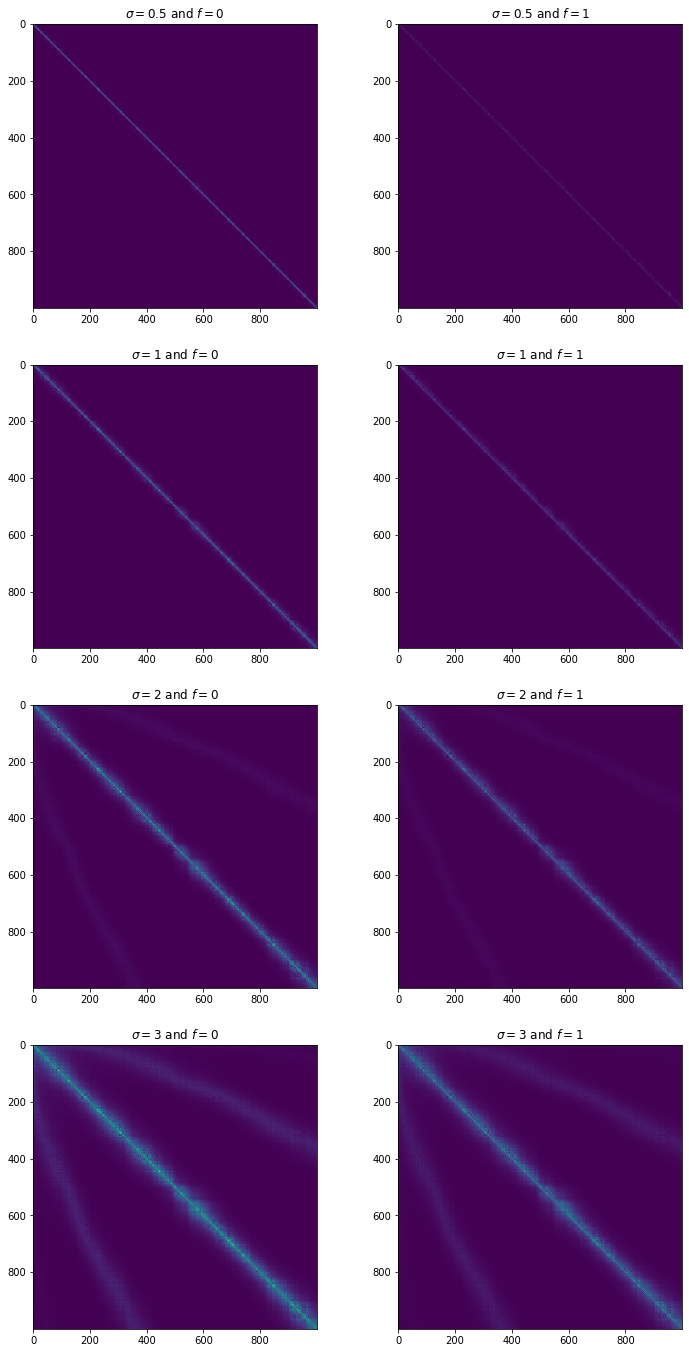

In [ ]:
affinity_grid_search(X,flow, sigmas = [0.5, 1, 2], flow_strengths = [0,1])

In [ ]:
X = torch.tensor(X).float().to(device)
flow = torch.tensor(flow).float().to(device)
X = X.float().to(device)
flow = flow.float().to(device)

## Testing the Diffusion Map

In [ ]:
Flow_around_the_DMAP = FlowEmbedderAroundDiffusionMap(X, flow, labels = labels, device = device)

diff map is [[-0.04488129+0.j -0.04561139+0.j -0.04530626+0.j ... -0.01822147+0.j
  -0.01781826+0.j -0.01951317+0.j]
 [-0.02811566+0.j -0.0291539 +0.j -0.02892254+0.j ...  0.04748999+0.j
   0.04719321+0.j  0.0497414 +0.j]
 [ 0.0310261 +0.j  0.03049149+0.j  0.03023334+0.j ...  0.00089583+0.j
   0.00127524+0.j  0.00152283+0.j]
 [ 0.01301177+0.j  0.01247852+0.j  0.01258752+0.j ... -0.0571522 +0.j
  -0.05672025+0.j -0.05764106+0.j]
 [ 0.03162169+0.j  0.03162165+0.j  0.03162168+0.j ...  0.03162396+0.j
   0.03162398+0.j  0.03162418+0.j]]
torch.Size([1000, 2])


  0%|          | 0/100 [00:00<?, ?it/s]

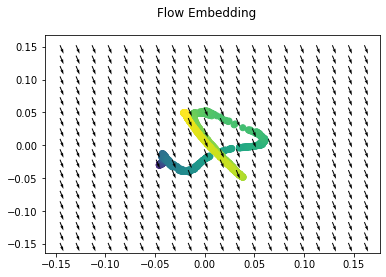

  1%|          | 1/100 [00:04<07:55,  4.80s/it]

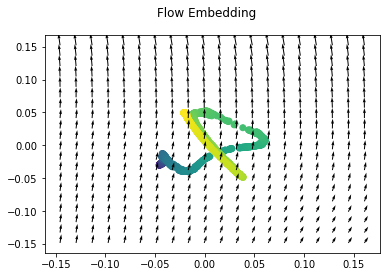

  2%|▏         | 2/100 [00:09<07:18,  4.47s/it]

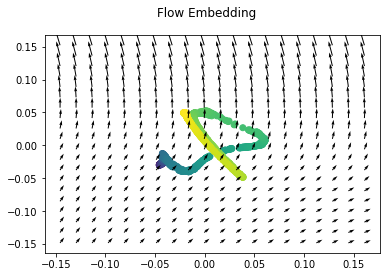

  3%|▎         | 3/100 [00:13<07:03,  4.36s/it]

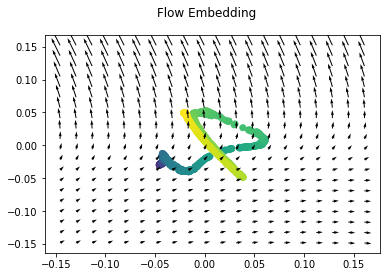

  4%|▍         | 4/100 [00:19<07:48,  4.88s/it]


KeyboardInterrupt: 

In [ ]:
Flow_around_the_DMAP.fit()

In [ ]:
Flow_around_the_DMAP.visualize_embedding()

AttributeError: 'FlowEmbedderAroundDiffusionMap' object has no attribute 'embedded_points'

In [ ]:
BOBO_FET.training_gif()

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP///////f//+///+f//9P//6f//1///tP7///z///v///n///…

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

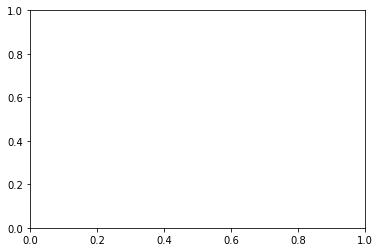

In [ ]:
BOBO_FET.visualize_loss()

In [ ]:
BOBO_FET.losses['diffusion']

100

In [ ]:
import glob
import ipywidgets as widgets
from PIL import Image
import os
import ipywidgets as widgets
import base64
frames = [Image.open(image) for image in glob.glob(f"visualizations/{BOBO_FET.timestamp}/*.jpg")]
frame_one = frames[0]
frame_one.save(f"{BOBO_FET.title}.gif", format="GIF", append_images=frames,
           save_all=True, duration=300, loop=0)
# display in jupyter notebook
b64 = base64.b64encode(open(f"{BOBO_FET.title}.gif",'rb').read()).decode('ascii')
display(widgets.HTML(f'<img src="data:image/gif;base64,{b64}" />'))

HTML(value='<img src="data:image/gif;base64,R0lGODlhsAEgAYcAAP///////f//+///+f//9P//6f//1///tP7///z///v///n///…